In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from tqdm import tqdm
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation_new as sim

/mnt/home/lduong/miniconda3/envs/frame/lib/python3.9/site-packages/scipy/__init__.py:162: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(


In [2]:
def simulate_one(n, eta_g, n_batch, frame, seed=0):
    assert frame in ["GRASSMANN", "RANDN"]
    np.random.seed(seed)
    # setup
    k = n * (n + 1) // 2
    V, _ = np.linalg.qr(np.random.randn(n, n))
    s = np.linspace(1, 5, n) + np.random.randn(n) * 0.1
    Cxx = V @ np.diag(s) @ V.T
    Lxx = np.linalg.cholesky(Cxx)
    kappa0 = np.linalg.cond(Cxx)
    if frame == "GRASSMANN":
        W, G, res = fw.get_grassmannian(n, k, niter=400)
    else: # frame == "RANDN":
        W = np.random.randn(n, k)
        W = fw.normalize_frame(W)

    g_last, g_all, errors, variances = sim.simulate([Lxx], W, 0, n_batch, eta_g, None, False, False) 

    return errors

errors = simulate_one(10, 1E-3, 2000, "RANDN", 10)

In [23]:
def simulate_many(n_repeats, frame):
    with multiprocessing.Pool() as pool:
        all_errors = []
        pbar = tqdm(total=n_repeats)
        for errors in pool.starmap(simulate_one, [(16, 1E-2, 10000, frame, i) for i in range(n_repeats)]):
            all_errors.append(errors)
            pbar.update(1)
    all_errors = np.array(all_errors)
    return all_errors

In [24]:
all_errors_randn = simulate_many(100, "RANDN")

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.06it/s]


In [26]:
all_errors_grassmann = simulate_many(100, "GRASSMANN")

100%|█████████████████████████████████████████| 100/100 [03:28<00:00,  2.09s/it]


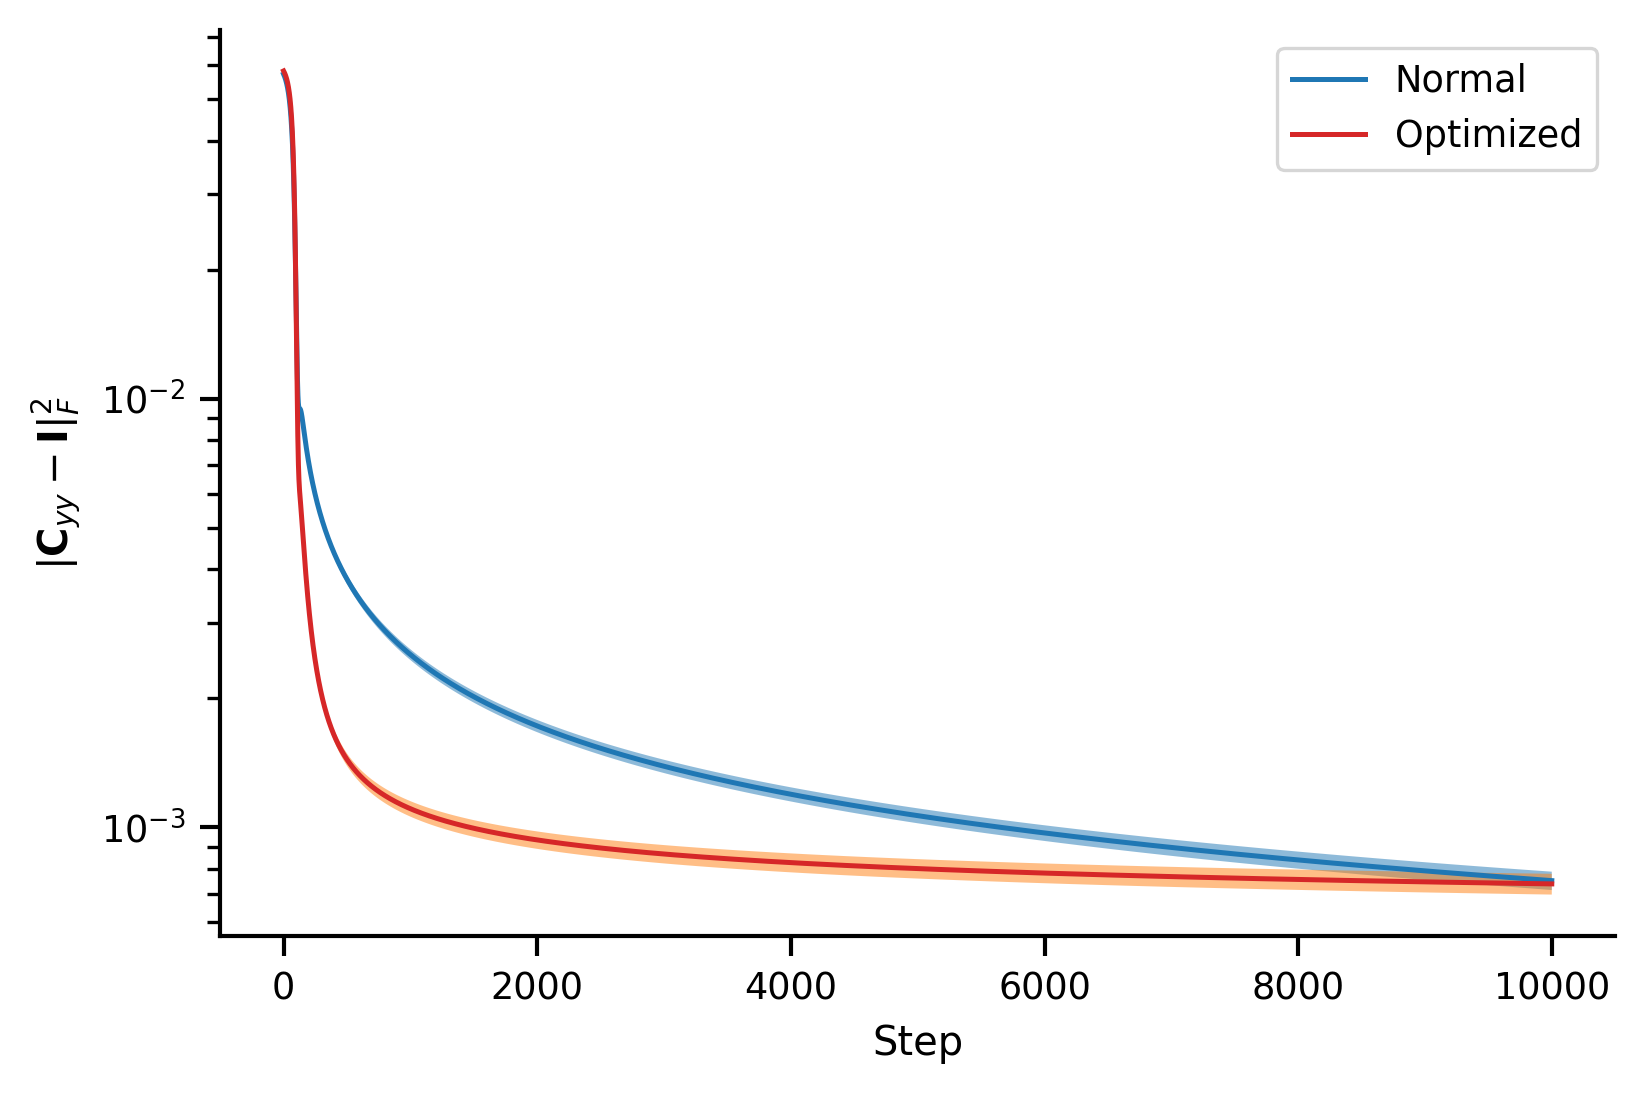

In [27]:
# fmt: off
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(1, 1, dpi=300)
    mu_randn = np.mean(all_errors_randn, axis=0)
    sig_randn = np.std(all_errors_randn, axis=0) / np.sqrt(all_errors_randn.shape[0])
    ax.plot(range(len(mu_randn)), mu_randn, color="C0", label="Normal")
    ax.fill_between(range(len(mu_randn)), mu_randn - sig_randn, mu_randn + sig_randn, alpha=0.5)

    mu_grassmann = np.mean(all_errors_grassmann, axis=0)
    sig_grassmann = np.std(all_errors_grassmann, axis=0) / np.sqrt(all_errors_grassmann.shape[0])

    ax.plot(range(len(mu_grassmann)), mu_grassmann, color="C3", label="Optimized")
    ax.fill_between(range(len(mu_randn)), mu_grassmann - sig_grassmann, mu_grassmann + sig_grassmann, alpha=0.5)

    ax.set(yscale="log", ylabel=r"$\|{\bf C}_{yy} - {\bf I}\|_F^2$", xlabel="Step")
    ax.legend()

    sns.despine()
# fmt: on